In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.set_random_seed(1)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
import matplotlib.pyplot as plt
import PIL.Image as Image
import math
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
import json
from tensorflow.keras.losses import mse
import os
import glob
import random
import sys
ros_path = '/opt/ros/kinetic/lib/python2.7/dist-packages'

if ros_path in sys.path:

    sys.path.remove(ros_path)

import cv2

sys.path.append('/opt/ros/kinetic/lib/python2.7/dist-packages')

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
import datetime
from tensorflow.keras.layers import Dense, Input, concatenate, Dropout, Conv2D, MaxPooling2D, Flatten, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from scipy.special import softmax
from keras import optimizers
%matplotlib inline


Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


# Model

In [2]:
# feature extraction from left image
left_img = Input(shape = (112,112,3), name="left_image")

left_phi_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=left_img, input_shape=(112,112,3))
left_phi_features = left_phi_model.output
left_flat = Flatten(name='left-phi-flattened')(left_phi_features)

# fx
pred_fx = Dense(1, name='fx')(left_flat)

# fy
pred_fy = Dense(1, name='fy')(left_flat)

# u0
pred_u0 = Dense(1, name='u0')(left_flat)

# v0
pred_v0 = Dense(1, name='v0')(left_flat)

# baseline
pred_baseline = Dense(1, name='baseline')(left_flat)

# tx
pred_x = Dense(1, name='x')(left_flat)

# ty
pred_y = Dense(1, name='y')(left_flat)

# tz
pred_z = Dense(1, name='z')(left_flat)

# pitch
pred_pitch = Dense(1, name='pitch')(left_flat)

# u
pred_u = Dense(1, name='u')(left_flat)

# v
pred_v = Dense(1, name='v')(left_flat)

# disparity
pred_disparity = Dense(1, name='disparity')(left_flat)

# yWorld
pred_yWorld = Dense(1, name='yWorld')(left_flat)

# xWorld
pred_xWorld = Dense(1, name='xWorld')(left_flat)

# zWorld
pred_zWorld = Dense(1, name='zWorld')(left_flat)

# create model
model = Model(inputs=[left_img], outputs=[pred_fx, pred_fy, pred_u0, pred_v0, pred_baseline, pred_disparity, pred_x, pred_y, pred_z, pred_pitch, pred_xWorld,pred_yWorld,pred_zWorld])

# set output types
target1 = tf.placeholder(dtype='float32', shape=(1,1)) 
target2 = tf.placeholder(dtype='float32', shape=(1,1))
target3 = tf.placeholder(dtype='float32', shape=(1,1))
target4 = tf.placeholder(dtype='float32', shape=(1,1)) 
target5 = tf.placeholder(dtype='float32', shape=(1,1))
target6 = tf.placeholder(dtype='float32', shape=(1,1))
target7 = tf.placeholder(dtype='float32', shape=(1,1)) 
target8 = tf.placeholder(dtype='float32', shape=(1,1))
target9 = tf.placeholder(dtype='float32', shape=(1,1))
target10 = tf.placeholder(dtype='float32', shape=(1,1)) 
target11 = tf.placeholder(dtype='float32', shape=(1,1))
target12 = tf.placeholder(dtype='float32', shape=(1,1))
target13 = tf.placeholder(dtype='float32', shape=(1,1))

# get model summary
model.summary()

learning_rate = 0.001

# compile model
model.compile(loss="mae", target_tensors=[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12, target13],optimizer=optimizers.Adam(lr=learning_rate))
plot_model(model, to_file='model.png')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_image (InputLayer)         [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 55, 55, 32)   864         left_image[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 55, 55, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 55, 55, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 11, 11, 64)   18432       concatenate_2[0][0]              
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 11, 11, 64)   192         conv2d_27[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 11, 11, 64)   0           batch_normalization_27[0][0]     
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 11, 11, 96)   55296       activation_27[0][0]              
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 11, 11, 96)   288         conv2d_28[0][0]                  
__________

__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 5, 5, 160)    480         conv2d_45[0][0]                  
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 5, 5, 160)    0           batch_normalization_45[0][0]     
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 5, 5, 160)    122880      concatenate_4[0][0]              
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 5, 5, 160)    179200      activation_45[0][0]              
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 5, 5, 160)    480         conv2d_41[0][0]                  
__________

__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 5, 5, 192)    147456      average_pooling2d_5[0][0]        
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 5, 5, 192)    576         conv2d_50[0][0]                  
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 5, 5, 192)    576         conv2d_53[0][0]                  
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, 5, 5, 192)    576         conv2d_58[0][0]                  
__________________________________________________________________________________________________
batch_normalization_59 (BatchNo (None, 5, 5, 192)    576         conv2d_59[0][0]                  
__________

batch_normalization_75 (BatchNo (None, 2, 2, 192)    576         conv2d_75[0][0]                  
__________________________________________________________________________________________________
activation_71 (Activation)      (None, 2, 2, 320)    0           batch_normalization_71[0][0]     
__________________________________________________________________________________________________
activation_75 (Activation)      (None, 2, 2, 192)    0           batch_normalization_75[0][0]     
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 2, 2, 768)    0           concatenate_7[0][0]              
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 2, 2, 1280)   0           activation_71[0][0]              
                                                                 activation_75[0][0]              
          

ValueError: Could not interpret optimizer identifier: <keras.optimizers.Adam object at 0x7fd3487ef430>

# Get data

In [3]:
data_path = "../Data/"

Left_images = np.load(data_path+"lir.npy")
Right_images = np.load(data_path+"rir.npy")
Fx = np.load(data_path+"fxr.npy")
Fy = np.load(data_path+"fyr.npy") 
U0 = np.load(data_path+"u0r.npy") 
V0 = np.load(data_path+"v0r.npy") 
Baseline = np.load(data_path+"br.npy")
Disparity = np.load(data_path+"dr.npy") 
Tx = np.load(data_path+"txr.npy") 
Ty = np.load(data_path+"tyr.npy") 
Tz = np.load(data_path+"tzr.npy") 
Pitch = np.load(data_path+"pr.npy")
X = np.load(data_path+"xr.npy")
Y = np.load(data_path+"yr.npy") 
Z = np.load(data_path+"zr.npy")


In [4]:
import os
from keras.callbacks import TensorBoard, LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten, Input
#from utils_regressor_focal_dist import RotNetDataGenerator, angle_error, CustomModelCheckpoint
from keras import optimizers
import numpy as np
import glob, math
from shutil import copyfile
import datetime, random
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session


model.load_weights('./new_logs/20221216-120919/model_multi_class/Best/weights_40_355.37.h5')



input_shape = (112, 112, 3)


output = model.predict(
    x=[Left_images],
    batch_size=16,
    verbose=1
)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [5]:
np.shape(output)

(13, 2914, 1)

Text(0, 0.5, '% Correct')

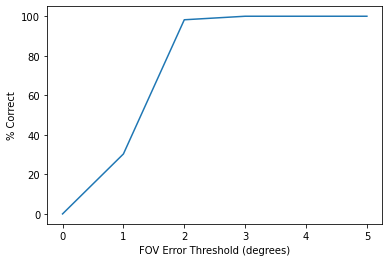

In [5]:
th_0 = 0
th_1 = 0
th_2 = 0
th_3 = 0
th_4 = 0
th_5 = 0

percent_correct = []

k = 0

for i  in range(np.shape(output)[1]):
    
    predicted_fov = 2*np.arctan(112/(2*output[0][i][0]))
    actual_fov = 2*np.arctan(112/(2*Fx[k]))
    
    if abs(predicted_fov - actual_fov) <= 0:
        
        th_0 += 1 
        
    if abs(predicted_fov - actual_fov) <= 1:
        
        th_1 += 1
        
    if abs(predicted_fov - actual_fov) <= 2:
        
        th_2 += 1
        
    if abs(predicted_fov - actual_fov) <= 3:
        
        th_3 += 1
        
    if abs(predicted_fov - actual_fov) <= 4:
        
        th_4 += 1
        
    if abs(predicted_fov - actual_fov) <= 5:
        
        th_5 += 1
        
    k += 1

percent_correct.append(th_0/np.shape(output)[1]*100)
percent_correct.append(th_1/np.shape(output)[1]*100)
percent_correct.append(th_2/np.shape(output)[1]*100)
percent_correct.append(th_3/np.shape(output)[1]*100)
percent_correct.append(th_4/np.shape(output)[1]*100)
percent_correct.append(th_5/np.shape(output)[1]*100)

plt.plot([0,1,2,3,4,5],percent_correct)
plt.xlabel("FOV Error Threshold (degrees)")
plt.ylabel("% Correct")

In [6]:
th_0, th_1, th_2, th_3, th_4, th_5

(0, 884, 2862, 2914, 2914, 2914)

In [7]:
th_0/np.shape(output)[1], th_1/np.shape(output)[1], th_2/np.shape(output)[1], th_3/np.shape(output)[1]

(0.0, 0.303363074811256, 0.9821551132463967, 1.0)

In [5]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0



key_counter = 0

for i in error.keys():
    
    k = 0

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += abs(predicted_fx - actual_fx)
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += abs(predicted_fy - actual_fy)
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += abs(predicted_u0 - actual_u0)
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += abs(predicted_v0 - actual_v0)
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += abs(predicted_baseline - actual_baseline)
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += abs(predicted_disparity - actual_disparity)
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += abs(predicted_tx - actual_tx)
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += abs(predicted_ty - actual_ty)
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += abs(predicted_tz - actual_tz)
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += abs(predicted_pitch - actual_pitch)
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += abs(predicted_x - actual_x)
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += abs(predicted_y - actual_y)
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += abs(predicted_z - actual_z)
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 2211.5724361920866, 'fy': 2210.6783488477145, 'u0': 986.6144224494236, 'v0': 474.6771065992581, 'baseline': 2.7472122300077384, 'disparity': 27.023248360225132, 'x': 1.1243188834871565, 'y': 3.7963878722190856, 'z': 1.1700808332783714, 'pitch': 104.93103714861348, 'xworld': 46.31415659514137, 'yworld': 37.86935314289764, 'zworld': 33.97193551028499}


# Normalized MAE

In [8]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0

mean_fx = 2282.8645019999262

mean_fy = 2281.794340454267

mean_u0 = 1042.0412599999809

mean_v0 = 529.8880620000258

mean_baseline = 0.20881100000000483

mean_disparity = 21.47887086050103

mean_tx = 2.0

mean_ty = 0.125

mean_tz = 1.2300000000000164

mean_pitch = 0.0219999999999989

mean_xw = 42.289555967764755

mean_yw = 18.34660238283241

mean_zw = 9.56192501636253


key_counter = 0

for i in error.keys():
    
    k = 0

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += abs(predicted_fx - actual_fx) / mean_fx 
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += abs(predicted_fy - actual_fy) / mean_fy
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += abs(predicted_u0 - actual_u0) / mean_u0
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += abs(predicted_v0 - actual_v0) / mean_v0
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += abs(predicted_baseline - actual_baseline) / mean_baseline
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += abs(predicted_disparity - actual_disparity) / mean_disparity
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += abs(predicted_tx - actual_tx) / mean_tx
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += abs(predicted_ty - actual_ty) / mean_ty
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += abs(predicted_tz - actual_tz) / mean_tz
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += abs(predicted_pitch - actual_pitch) / mean_pitch
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += abs(predicted_x - actual_x) / mean_xw
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += abs(predicted_y - actual_y) / mean_yw
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += abs(predicted_z - actual_z) / mean_zw
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 0.9626377355348519, 'fy': 0.9625481639135273, 'u0': 0.9470376674566165, 'v0': 0.8957915094745876, 'baseline': 135.2461312258254, 'disparity': 1.5867222794986793, 'x': 15.066588545590127, 'y': 23.71812987065757, 'z': 1.379085208622302, 'pitch': 443.23346291320826, 'xworld': 1.3963291583760415, 'yworld': 0.8498055725622399, 'zworld': 7.147843754763102}
